In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Projects/2023-HJ-Prox/src/')

from hj_prox import *
from functions import *
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
device = 'cuda:0'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Given gradient of Moreau envelope
\begin{equation}
  \nabla u^\delta(x,t) = \dfrac{1}{t}\cdot  \dfrac{\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[(x-y) \exp\left(-\delta^{-1}\tilde{f}(y)\right) \right]}
    {\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[ \exp\left(-\delta^{-1} \tilde{f}(y)\right) \right]} = \dfrac{1}{t} \left(x -  \dfrac{\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[(y) \exp\left(-\delta^{-1}\tilde{f}(y)\right) \right]}
    {\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[ \exp\left(-\delta^{-1} \tilde{f}(y)\right) \right]}\right)
\end{equation}

The proximal can be approximated as

\begin{equation}
  \text{prox}_{tf}(x) = x - t \nabla u(x,t)
\end{equation}

### Performing ISTA with prox_HJ

In [2]:
dim = 1000
A = torch.randn(int(dim/2), dim, device=device)
# x_true = torch.zeros(dim,1, device=device)
# x_true[500:600] = torch.randn(100, 1, device=device) 
# b = A.matmul(x_true)
b = torch.randn(int(dim/2), 1, device=device)
lambd = 1.0
step_size = 5e-4

def f(x, A, lambd = 1e-2): 
  # assumes x has shape n_samples x n_features
  temp = A.matmul(x.permute(1,0)) - b # has n_features x n_samples
  temp = temp.permute(1,0) # permute back to n_samples x n_features
  return 0.5*torch.norm(temp, dim=1)**2 + lambd*torch.norm(x, p=1, dim=1)


# ---------------------------------------------------------------------------------------------------
# ISTA
# ---------------------------------------------------------------------------------------------------
def ista(x0, f, A, lambd, step_size, max_iters, tol=1e-6, verbose=True):

  assert len(x0.shape)==2 and x0.shape[1]==1
  xk = x0
  xk_GD = x0 #########################################################
  fk_hist = torch.zeros(max_iters)
  norm_diff_hist = torch.zeros(max_iters)
  fk_hist_GD = torch.zeros(max_iters)

  for i in range(max_iters):

    start_time = time.time()
    yk = xk - step_size * A.t().matmul(A.matmul(xk)-b)
    yk = l1_norm_prox(yk, t=lambd*step_size)

    xk_GD =  xk_GD - step_size * A.t().matmul(A.matmul(xk_GD)-b) ######################################################

    norm_diff = torch.norm(yk - xk)
    fk = f(yk.permute(1,0), A, lambd=lambd) # need to input xk with dimensions (n_samples x 1)
    fk_GD = f(xk_GD.permute(1,0), A, lambd=lambd) # need to input xk with dimensions (n_samples x 1) ##########################################

    xk = yk.clone()

    fk_hist[i] = fk.cpu()
    fk_hist_GD[i] = fk_GD.cpu()
    norm_diff_hist[i] = norm_diff.cpu()
    
    end_time = time.time()
    iter_time = end_time - start_time

    if verbose:
      print('iter = ', i+1, ', f(xk) = ', fk.cpu(), ', norm_diff = ', norm_diff.cpu(), ', time = ', iter_time, fk_GD)

    if norm_diff < tol:
      fk_hist = fk_hist[0:i]
      norm_diff_hist = norm_diff_hist[0:i]
      fk_hist_GD = fk_hist_GD[0:i]
      break

  return xk, fk_hist, norm_diff_hist, fk_hist_GD

# ---------------------------------------------------------------------------------------------------
# HJ ISTA
# ---------------------------------------------------------------------------------------------------
def hj_ista(x0, f, A, lambd, step_size, max_iters, int_samples=100, delta=1e-1, tol=1e-6, verbose=True):

  print('LAMBD = ', lambd)

  assert len(x0.shape)==2 and x0.shape[1]==1
  xk = x0
  fk_hist = torch.zeros(max_iters)
  norm_diff_hist = torch.zeros(max_iters)

  for i in range(max_iters):

    start_time = time.time()
    yk = xk - step_size * A.t().matmul(A.matmul(xk)-b)
    yk = yk, linesearch_iters, temo = compute_prox(yk, lambd*step_size, l1_norm, delta=delta, int_samples=int_samples, alpha=1.0, device=device)

    norm_diff = torch.norm(yk - xk)
    fk = f(xk.permute(1,0), A, lambd=lambd) # need to input xk with dimensions (n_samples x 1)

    xk = yk

    fk_hist[i] = fk.cpu()
    norm_diff_hist[i] = norm_diff.cpu()
    
    end_time = time.time()
    iter_time = end_time - start_time

    if verbose:
      print('iter = ', i, ', f(xk) = ', fk, ', norm_diff = ', norm_diff, ', linesearch = ', linesearch_iters, ', time = ', iter_time)

    # if norm_diff < tol:
    #   fk_hist = fk_hist[0:i]
    #   norm_diff_hist = norm_diff_hist[0:i]
    #   break

  return xk, fk_hist, norm_diff_hist

In [3]:
x0 = torch.randn(A.shape[1], 1, device=device)

# Compute numerical "true" solution f_star
start_time_ista = time.time()
xopt_ista, fk_ista_hist, norm_diff_ista_hist, fk_GD_hist = ista(x0, f, A, lambd, step_size, int(1e4), verbose=False)
end_time_ista = time.time()

time_ista = end_time_ista - start_time_ista
print('ista finished running after ', time_ista)

ista finished running after  6.848653554916382


In [4]:
f_star = min(fk_ista_hist); print('f_star = ', f_star)

f_star =  tensor(19.8150)


In [6]:
max_iters = int(1e4)

#### Run HJ ISTA for different number of samples

In [7]:
# Average runs over 30 trials: standalone
n_trials = 1
sample_array = [int(1e2), int(1e3), int(1e4)]

xopt_HJ_ista_array = torch.zeros(len(sample_array), xopt_ista.shape[0], xopt_ista.shape[1])
fk_HJ_ista_hist_array = torch.zeros(len(sample_array), max_iters)
norm_diff_HJ_ista_hist_array = torch.zeros(len(sample_array), max_iters)

for sample_index in range(len(sample_array)):
  print('Number of Samples =', sample_array[sample_index])
  for i in range(n_trials):
    start_time_hj_ista = time.time()
    current_samples = sample_array[sample_index]
    xopt_HJ_ista_temp, fk_HJ_ista_hist_temp, norm_diff_HJ_ista_hist_temp = hj_ista(x0, f, A, lambd, step_size, max_iters, int_samples=current_samples, delta=1.0, verbose=False)
    end_time_hj_ista = time.time()
    time_hj_ista = end_time_hj_ista - start_time_hj_ista
    print('trial ', i+1, ' finished after', time_hj_ista)
    
    if i==0:
      xopt_HJ_ista, fk_HJ_ista_hist, norm_diff_HJ_ista_hist = xopt_HJ_ista_temp, fk_HJ_ista_hist_temp, norm_diff_HJ_ista_hist_temp
    else:
      xopt_HJ_ista = xopt_HJ_ista + xopt_HJ_ista_temp
      fk_HJ_ista_hist = fk_HJ_ista_hist + fk_HJ_ista_hist_temp
      norm_diff_HJ_ista_hist = norm_diff_HJ_ista_hist + norm_diff_HJ_ista_hist_temp

  xopt_HJ_ista_array[sample_index, :, :] = xopt_HJ_ista/n_trials
  fk_HJ_ista_hist_array[sample_index, :] = fk_HJ_ista_hist/n_trials
  norm_diff_HJ_ista_hist_array[sample_index, :] = norm_diff_HJ_ista_hist/n_trials

Number of Samples = 100
LAMBD =  1.0
trial  1  finished after 10.023954629898071
Number of Samples = 1000
LAMBD =  1.0
trial  1  finished after 8.753089904785156
Number of Samples = 10000
LAMBD =  1.0
trial  1  finished after 11.900594472885132


<ipython-input-9-4a7a49eff751>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 640x480 with 0 Axes>

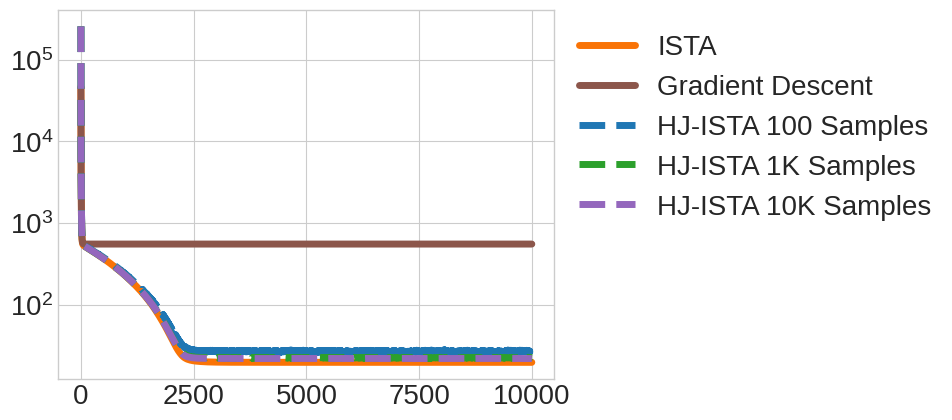

In [9]:
# plotting parameters
title_fontsize = 22
fontsize       = 20
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

f_star = 0.0

ax.semilogy(fk_ista_hist[0:max_iters] - f_star, linewidth=5, color=my_orange)
ax.semilogy(fk_GD_hist[0:max_iters] - f_star, linewidth=5, color='tab:brown')
ax.semilogy(fk_HJ_ista_hist_array[0,:] - f_star, '--', linewidth=5, color=my_blue)
ax.semilogy(fk_HJ_ista_hist_array[1,:] - f_star, '--', linewidth=5, color='tab:green')
ax.semilogy(fk_HJ_ista_hist_array[2,:] - f_star, '--', linewidth=5, color='tab:purple')

# fig1.set_figwidth(5.5)
# fig1.set_figheight(5.4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['ISTA', 'Gradient Descent', 'HJ-ISTA 100 Samples', 'HJ-ISTA 1K Samples', 'HJ-ISTA 10K Samples'],fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'ISTA_sample_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### HJ ISTA Delta Comparison

In [10]:
# Average runs over 30 trials: standalone
delta_array = [1e-2, 1e-1, 1e0]

xopt_HJ_ista_array = torch.zeros(len(delta_array), xopt_ista.shape[0], xopt_ista.shape[1])
fk_HJ_ista_hist_array = torch.zeros(len(delta_array), max_iters)
norm_diff_HJ_ista_hist_array = torch.zeros(len(delta_array), max_iters)

for delta_index in range(len(delta_array)):
  print('Delta Index =', delta_array[delta_index])
  for i in range(n_trials):
    start_time_hj_ista = time.time()
    current_delta = delta_array[delta_index]
    xopt_HJ_ista_temp, fk_HJ_ista_hist_temp, norm_diff_HJ_ista_hist_temp = hj_ista(x0, f, A, lambd, step_size, max_iters, int_samples=int(1e3), delta=current_delta, verbose=False)
    end_time_hj_ista = time.time()
    time_hj_ista = end_time_hj_ista - start_time_hj_ista
    print('trial ', i+1, ' finished after', time_hj_ista)
      
    if i==0:
      xopt_HJ_ista, fk_HJ_ista_hist, norm_diff_HJ_ista_hist = xopt_HJ_ista_temp, fk_HJ_ista_hist_temp, norm_diff_HJ_ista_hist_temp
    else:
      xopt_HJ_ista = xopt_HJ_ista + xopt_HJ_ista_temp
      fk_HJ_ista_hist = fk_HJ_ista_hist + fk_HJ_ista_hist_temp
      norm_diff_HJ_ista_hist = norm_diff_HJ_ista_hist + norm_diff_HJ_ista_hist_temp


  xopt_HJ_ista_array[delta_index, :, :] = xopt_HJ_ista/n_trials
  fk_HJ_ista_hist_array[delta_index, :] = fk_HJ_ista_hist/n_trials
  norm_diff_HJ_ista_hist_array[delta_index, :] = norm_diff_HJ_ista_hist/n_trials

Delta Index = 0.01
LAMBD =  1.0
trial  1  finished after 8.748048067092896
Delta Index = 0.1
LAMBD =  1.0
trial  1  finished after 8.673576831817627
Delta Index = 1.0
LAMBD =  1.0
trial  1  finished after 8.724540948867798


<ipython-input-11-c1c409b9edbb>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 640x480 with 0 Axes>

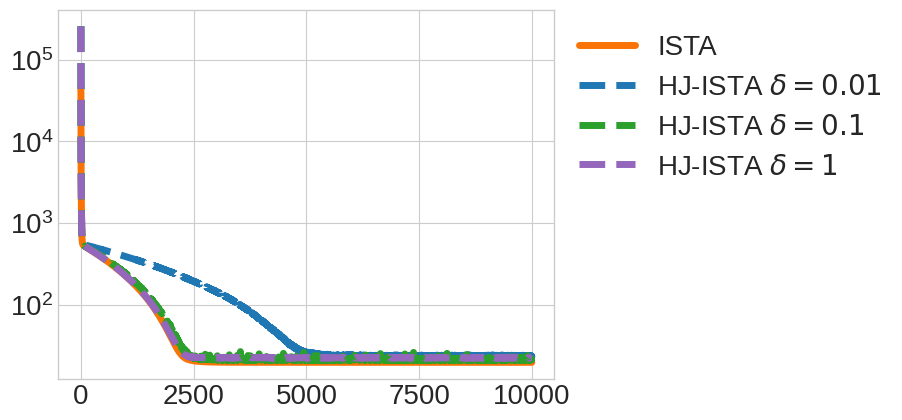

In [11]:
# plotting parameters
title_fontsize = 22
fontsize       = 20
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.semilogy(fk_ista_hist[0:max_iters], linewidth=5, color=my_orange)
ax.semilogy(fk_HJ_ista_hist_array[0,:], '--', linewidth=5, color=my_blue)
ax.semilogy(fk_HJ_ista_hist_array[1,:], '--', linewidth=5, color='tab:green')
ax.semilogy(fk_HJ_ista_hist_array[2,:], '--', linewidth=5, color='tab:purple')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['ISTA', 'HJ-ISTA $\delta=0.01$', 'HJ-ISTA $\delta=0.1$', 'HJ-ISTA $\delta=1$',],fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'ISTA_delta_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)